In this notebook, we're going to inspect the "model_data.xlsx" dataset and see the attributes it has. 

In [18]:
!pip install openpyxl pandas matplotlib

  Using cached cycler-0.12.1-py3-none-any.whl.metadata (3.8 kB)
  Using cached pyparsing-3.2.3-py3-none-any.whl.metadata (5.0 kB)
   ---------------------------------------- 0.0/8.1 MB ? eta -:--:--
   ---------------------------------------- 8.1/8.1 MB 46.2 MB/s  0:00:00
Using cached cycler-0.12.1-py3-none-any.whl (8.3 kB)
   ---------------------------------------- 0.0/2.3 MB ? eta -:--:--
   ---------------------------------------- 2.3/2.3 MB 46.6 MB/s  0:00:00
   ---------------------------------------- 0.0/7.0 MB ? eta -:--:--
   ---------------------------------------- 7.0/7.0 MB 51.6 MB/s  0:00:00
Using cached pyparsing-3.2.3-py3-none-any.whl (111 kB)

   ---------------------------------------- 0/7 [pyparsing]
   ----- ---------------------------------- 1/7 [pillow]
   ----- ---------------------------------- 1/7 [pillow]
   ----- ---------------------------------- 1/7 [pillow]
   ----- ---------------------------------- 1/7 [pillow]
   ----- ---------------------------------- 

In [ ]:
import pandas as pd

In [8]:
df = pd.read_excel("model_data.xlsx")
df = df.dropna()
df.head()

,Record_date,Loan_id,User_id,Application_id,Country,Loan Status,Loan_type,Open_date,Open_month,Original_balance,...,ATM_withdrawals_last_90_days,Other_credit_lines,Reported_in_credit_bureau,Customer Score,DPD >30@ 3MOB Flag,Unique 30@3 Flag,DPD >60@6 MOB Flag,Unique 60@6 Flag,DPD >90@12 MOB Flag,Unique 90@12 Flag
964,2024-02-29,414.0,414.0,3368.0,FR,Active,Unsecured Loan,2024-02-02,2024-02-29,10000.0,...,840.0,0.0,0.0,20.0,0.0,0.0,0.0,0.0,0.0,0.0
1042,2024-02-29,492.0,492.0,3927.0,FR,Active,Unsecured Loan,2024-02-07,2024-02-29,1000.0,...,0.0,0.0,0.0,16.0,0.0,0.0,0.0,0.0,0.0,0.0
1048,2024-02-29,498.0,498.0,3984.0,FR,Active,Unsecured Loan,2024-02-08,2024-02-29,1000.0,...,0.0,0.0,0.0,18.0,0.0,0.0,0.0,0.0,0.0,0.0
1049,2024-02-29,499.0,499.0,3986.0,FR,Active,Unsecured Loan,2024-02-08,2024-02-29,2000.0,...,0.0,0.0,0.0,22.0,0.0,0.0,0.0,0.0,0.0,0.0
1069,2024-02-29,519.0,519.0,4167.0,FR,Active,Unsecured Loan,2024-02-09,2024-02-29,10000.0,...,0.0,0.0,0.0,22.0,0.0,0.0,0.0,0.0,0.0,0.0


In [12]:
df["Loan_id"].is_unique

False

As we can see, the Loan_ids are not unique. This is because there are multiple entries for each loan since as defaulting loans grow older (Default> 30 days --> Default> 60 days --> Default> 90 days), they are re-entered into the data, with the exact same data except for changes in the DPD >30@ 3MOB Flag.

Example: 

If they are 30 days over, the loans would have a 1 at DPD >30@ 3MOB Flag. 
When they go over 30 days, DPD >30@ 3MOB Flag == 0, and DPD >60@ 6MOB Flag == 1. 

This is what creates the duplicates.

To solve this issue, we can compress these 3 columns into 1 (note: we are losing some information).


In [15]:

df_unique = df.sort_values(by=["Loan_id", "Record_date"])

# 1. Get the first DPD >30 default record per Loan_id
df_default_30 = df_unique[df_unique["DPD >30@ 3MOB Flag"] == 1].groupby("Loan_id").head(1)

# 2. Get the last available observation for loans that NEVER defaulted at 30 days
non_default_loans = df_unique[~df_unique["Loan_id"].isin(df_default_30["Loan_id"])]
df_non_default = non_default_loans.groupby("Loan_id").tail(1)

# 3. Combine into final dataset
df_unique = pd.concat([df_default_30, df_non_default], axis=0).sort_values("Loan_id")

# 4. Define target column explicitly
df_unique["target_default_30"] = df_unique["DPD >30@ 3MOB Flag"].astype(int)

df_unique.head()

,Record_date,Loan_id,User_id,Application_id,Country,Loan Status,Loan_type,Open_date,Open_month,Original_balance,...,Other_credit_lines,Reported_in_credit_bureau,Customer Score,DPD >30@ 3MOB Flag,Unique 30@3 Flag,DPD >60@6 MOB Flag,Unique 60@6 Flag,DPD >90@12 MOB Flag,Unique 90@12 Flag,target_default_30
3047,2024-04-30,414.0,414.0,3368.0,FR,Active,Unsecured Loan,2024-02-02,2024-02-29,10000.0,...,0.0,0.0,20.0,1.0,1.0,0.0,0.0,0.0,0.0,1
51917,2025-02-28,492.0,492.0,3927.0,FR,Active,Unsecured Loan,2024-02-07,2024-02-29,1000.0,...,0.0,0.0,16.0,0.0,0.0,0.0,0.0,0.0,0.0,0
51923,2025-02-28,498.0,498.0,3984.0,FR,Active,Unsecured Loan,2024-02-08,2024-02-29,1000.0,...,0.0,0.0,18.0,0.0,0.0,0.0,0.0,0.0,0.0,0
51924,2025-02-28,499.0,499.0,3986.0,FR,Active,Unsecured Loan,2024-02-08,2024-02-29,2000.0,...,0.0,0.0,22.0,0.0,0.0,0.0,0.0,0.0,0.0,0
51944,2025-02-28,519.0,519.0,4167.0,FR,Inactive,Unsecured Loan,2024-02-09,2024-02-29,10000.0,...,0.0,0.0,22.0,0.0,0.0,0.0,0.0,0.0,0.0,0


In [16]:
df_unique["Loan_id"].is_unique


True

While we are losing information as now we cannot distinguish between those defaults which are 90 days or pay back after 30 days, this makes modeling the dataset much easier. Additonally, we benefit from an increase in class as we have a huge class imbalance between non-default/default (as seen below). 

target_default_30
0    1768
1      67
Name: count, dtype: int64


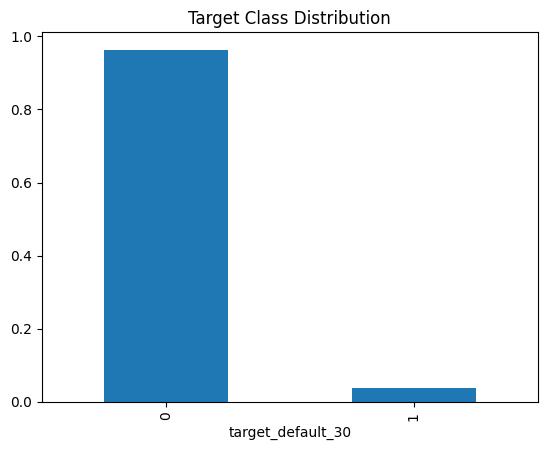

In [19]:
df_unique["target_default_30"].value_counts(normalize=True).plot(kind="bar", title="Target Class Distribution")
print(df_unique["target_default_30"].value_counts())

We experimented with synthetic data generation, but in the interest of replicating the most realistic scenarios for the model to train on, we decided against it. 

This just means we're going to be extra careful when looking for overfitting signs.

Lastly, since the testing dataset (test_data.xlsx) does not have the same columns as our training data, we will keep only the columns that exist in both datasets, removing any columns that are exclusive to either dataset.


In [20]:
test_df = pd.read_excel("test_data.xlsx")

In [21]:
common_cols = test_df.columns.intersection(df_unique.columns)

# columns common between test_df and df_unique
common_cols = test_df.columns.intersection(df_unique.columns)

# Keep target column in df_unique
if "target_default_30" in df_unique.columns:
    common_cols = common_cols.append(pd.Index(["target_default_30"]))

df_unique_aligned = df_unique[common_cols]

test_df_aligned = test_df[common_cols.drop("target_default_30", errors='ignore')]

In [22]:
print("Training columns:", df_unique_aligned.columns)
print("Testing columns:", test_df_aligned.columns)

Training columns: Index(['Application_id', 'User_id', 'Country', 'Original_balance',
       'Term_at_origination', 'PD_at_Origination', 'Credit_grade', 'APR',
       'Monthly Installment', 'Age to Use', 'Declared_accommodation_type',
       'Income to Use', 'Days_as_customer', 'Transactions_in_last_30_days',
       'Min_bal_last_30_days', 'Gambling_transactions_last_90_days',
       'ATM_withdrawals_last_90_days', 'Other_credit_lines',
       'Reported_in_credit_bureau', 'Customer Score', 'target_default_30'],
      dtype='object')
Testing columns: Index(['Application_id', 'User_id', 'Country', 'Original_balance',
       'Term_at_origination', 'PD_at_Origination', 'Credit_grade', 'APR',
       'Monthly Installment', 'Age to Use', 'Declared_accommodation_type',
       'Income to Use', 'Days_as_customer', 'Transactions_in_last_30_days',
       'Min_bal_last_30_days', 'Gambling_transactions_last_90_days',
       'ATM_withdrawals_last_90_days', 'Other_credit_lines',
       'Reported_in_cre

As we can see, they are now the same! 

We will save these new datasets: 

**model_data_cleaned.xlsx**

**test_data_cleaned.xlsx**


In [23]:
test_df_aligned = test_df_aligned.dropna()


In [24]:
df_unique_aligned.to_excel("model_data_cleaned.xlsx", index=False)

test_df_aligned.to_excel("test_data_cleaned.xlsx", index=False)